# Applying the XGBoost Algorithm

So far you've learned to apply a variety of different models. In this notebook you should prepare the data, import the XGBClassifier, train it and make predictions on your own. (Feel free to tune the hyperparameters in the end using a grid or random search!). 

We'll use the pima-native-americans-diabetic dataset for this task. You can find it in the data folder. You will see that the dataset is lacking column names. Therefore we added them as a list in one of the cells below. Have a look at the documentation. It is possible to import the data and directly add the columns names (they are in the correct order). 

If you need help or inspiration you can have a look at this [blogpost](https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/), describing how to use the XGBoost Algorithm. 

## Import and Setup

In [15]:
# Import modules
from xgboost import XGBClassifier

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from itertools import product

import warnings
warnings.filterwarnings("ignore")

RSEED=42

In [16]:
# Import data
df = pd.read_csv('data/pima-native-americans-diabetes.csv')
column_names = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree_function', 'age', 'outcome']
# Set columns names of data frame
df.columns = column_names

In [17]:
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,outcome
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [18]:
# Split the data
X = df.drop('outcome', axis=1)
y = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RSEED)

In [19]:
# Fit model to training data
xgb = XGBClassifier(random_state=RSEED,
                    n_jobs=-1,
                    #n_estimators=1000,
                    #learning_rate=0.3,
                    #subsample=0.5,
                    )
xgb.fit(X_train, y_train)
# Make predictions on test set
y_pred = xgb.predict(X_test)

In [20]:
# Evaluate your model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.80      0.80       151
           1       0.63      0.64      0.63        80

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.75      0.74      0.74       231



Text(50.722222222222214, 0.5, 'Actual')

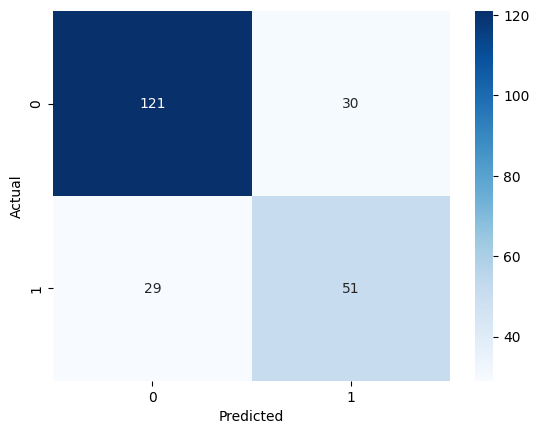

In [21]:
# Show confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot with seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Instead of predicting a few individual values a useful trick can be to predict for a whole matrix of values rather than for just the test set. 

In [22]:
#Function to produce a row with regular intervals
def make_row(row_length,row_min,row_max,):
    step = (row_max - row_min)/row_length
    row = []
    for i in range(0,row_length+1):
#        print(df._STATE.min()+(step*i))
        row.append(row_min+(step*i))

    return row



In [23]:
#Produce a grid. 
grid = pd.DataFrame()

for i in X_train.columns:
    row_min = X_train[i].min()
    row_max = X_train[i].max()
    row = make_row(3,row_min,row_max) #Selecting a high value here will result in long waiting time in the next step
    grid[i] = row

grid

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.078000,21.0
1,5.0,66.0,40.666667,21.0,282.0,22.366667,0.858667,41.0
2,10.0,132.0,81.333333,42.0,564.0,44.733333,1.639333,61.0
3,15.0,198.0,122.000000,63.0,846.0,67.100000,2.420000,81.0


In [24]:
#Create permutations of all possible values

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

dictionary = {}
for i in grid.columns:
    dictionary.update({i : grid[i]})

full_grid = expand_grid(dictionary)

full_grid


,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
0,0.0,0.0,0.0,0.0,0.0,0.0,0.078000,21.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.078000,41.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.078000,61.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.078000,81.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.858667,21.0
...,...,...,...,...,...,...,...,...
65531,15.0,198.0,122.0,63.0,846.0,67.1,1.639333,81.0
65532,15.0,198.0,122.0,63.0,846.0,67.1,2.420000,21.0
65533,15.0,198.0,122.0,63.0,846.0,67.1,2.420000,41.0
65534,15.0,198.0,122.0,63.0,846.0,67.1,2.420000,61.0


In [25]:
#predict the full grid using the model
prob = xgb.predict_proba(full_grid)

#extract positive predictions and assign them to a column in full_grid
full_grid['prob'] = prob[:,1]



In [26]:
full_grid.tail(100)

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,prob
65436,15.0,198.0,122.0,63.0,564.0,22.366667,2.420000,21.0,0.764459
65437,15.0,198.0,122.0,63.0,564.0,22.366667,2.420000,41.0,0.849952
65438,15.0,198.0,122.0,63.0,564.0,22.366667,2.420000,61.0,0.856744
65439,15.0,198.0,122.0,63.0,564.0,22.366667,2.420000,81.0,0.654012
65440,15.0,198.0,122.0,63.0,564.0,44.733333,0.078000,21.0,0.917409
...,...,...,...,...,...,...,...,...,...
65531,15.0,198.0,122.0,63.0,846.0,67.100000,1.639333,81.0,0.977991
65532,15.0,198.0,122.0,63.0,846.0,67.100000,2.420000,21.0,0.943005
65533,15.0,198.0,122.0,63.0,846.0,67.100000,2.420000,41.0,0.943849
65534,15.0,198.0,122.0,63.0,846.0,67.100000,2.420000,61.0,0.988184


Above you can see the last 100 rows from the matrix we have created with the probability of diabetes calculated. This lookup table is an approximation of the model we've created - although it is not as precise as the model it can be used for various purposes - as plan B for your main model when it goes offline or as way to visualise the representation of the world your model has built. 

In [27]:
#save the grid to a csv file - be ware of exceptionally large csv files
full_grid.to_csv('data/full_grid.csv')



In [28]:
#extract the most important features from the model
imp = list(zip(xgb.feature_names_in_,xgb.feature_importances_))
imp.sort(key = lambda tuple:tuple[1],reverse= True)
imp[0:2]

[('glucose', 0.24065238), ('age', 0.1376784)]

In [29]:
#We can visualise a maximum of 3 variables, so lets group by the 2 most important variables and compute the mean
grid_slice = full_grid.groupby(['glucose','bmi'],as_index=False).mean()

grid_slice

,glucose,bmi,pregnancies,blood_pressure,skin_thickness,insulin,diabetes_pedigree_function,age,prob
0,0.0,0.000000,7.5,61.0,31.5,423.0,1.249,51.0,0.156671
1,0.0,22.366667,7.5,61.0,31.5,423.0,1.249,51.0,0.092648
2,0.0,44.733333,7.5,61.0,31.5,423.0,1.249,51.0,0.451605
3,0.0,67.100000,7.5,61.0,31.5,423.0,1.249,51.0,0.554692
4,66.0,0.000000,7.5,61.0,31.5,423.0,1.249,51.0,0.156671
5,66.0,22.366667,7.5,61.0,31.5,423.0,1.249,51.0,0.092648
6,66.0,44.733333,7.5,61.0,31.5,423.0,1.249,51.0,0.451605
7,66.0,67.100000,7.5,61.0,31.5,423.0,1.249,51.0,0.554692
8,132.0,0.000000,7.5,61.0,31.5,423.0,1.249,51.0,0.212979
9,132.0,22.366667,7.5,61.0,31.5,423.0,1.249,51.0,0.187736


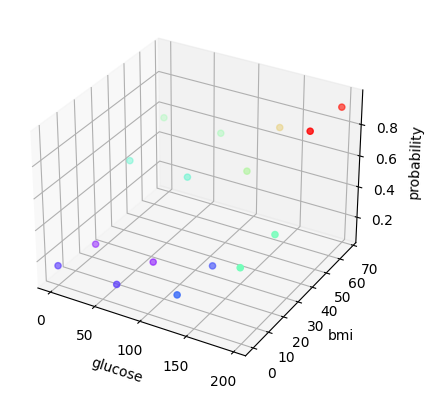

In [30]:
#create a 3D visualisation of the resulting probability vs 2 most important prediction variables plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

xs = grid_slice.glucose
ys = grid_slice.bmi
zs = grid_slice.prob
ax.scatter3D(xs, ys, zs, marker='o', c = zs, cmap = 'rainbow')

ax.set_xlabel('glucose')
ax.set_ylabel('bmi')
ax.set_zlabel('probability')

plt.show()

